In [ ]:
! pip install .

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md
%matplotlib inline
import numpy as np

In [2]:
from  latam_challenge.helpers.constants import ( FECHAO, FECHAI, DATE, TIME, ATRASO_15, PERIODO_DIA, TEMPORADA_ALTA, 
                                                COLUM_FILTER, VLOI, DIA, MES, ANIO, DIANOM, TIPOVUELO, OPERA, 
                                                SIGLADES, COLUM_SYNTHETIC_FEATURES, PARAM_GRID, COHORT)

In [3]:
# Local functions
from latam_challenge.helpers.utils import ( add_temporada_alta_flag,  split_date, add_periodo_dia_flag, 
                                            add_dif_min_and_atraso_15, generate_temporada_alta_set,
                                            generate_day_section, apply_cohort, delete_operational_columns,
                                            one_hot_encoder, filter_column, to_bool_tipo_vuelo, fit_grid_model)

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [6]:
# read dataframe
df = pd.read_csv("latam_challenge/sources/raw/dataset_SCL.csv", dtype={'Vlo-O':str, 'Vlo-I':str})
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [7]:
# check for nulls and type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


Only one null valio on `Vlo-O`, if a value is object could be date or string

# Fecha-I
---
First field is the Fecha-I, this field has the date and the hour, so we are going to split it in two to review the distribution of the programated date, the main idea is to detect the distribution over the date

In [8]:
HOUR = 'hour'
df[FECHAI] = pd.to_datetime(df[FECHAI])
df[DATE] = df['Fecha-I'].dt.date
df[TIME] = df['Fecha-I'].dt.time
df[HOUR] = df['Fecha-I'].dt.hour
md(f"Number of days on the dataframe {df[DATE].nunique()}")


Number of days on the dataframe 365

In the following image, we can see that we only have information of one year, were we can said that we could have lowest demand between mars to july. This is because for the south part is winter. However, there is increse in the second semester due is summer in that region

In [9]:
to_plot = df.groupby([DATE])[DATE].count().rename("count")
to_plot = to_plot.reset_index()

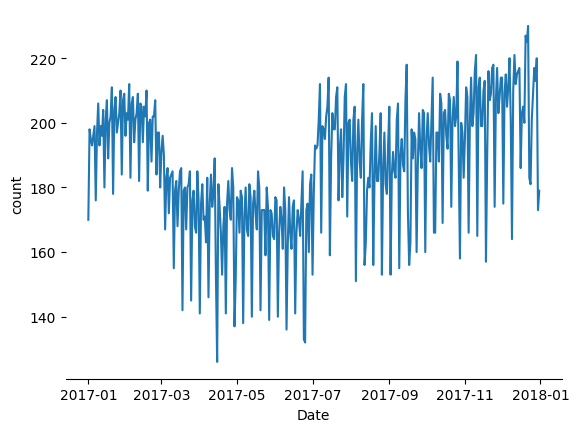

In [10]:
sns.lineplot(x=DATE, y = 'count', data = to_plot, palette = sns.color_palette("Set2",1))
sns.despine(left=True)

During this year, we have a record, that at least one fly can is register every hour, but in the distribution we can see preference, such as 1:00, 6:00, 8:00, and 17:00 hours

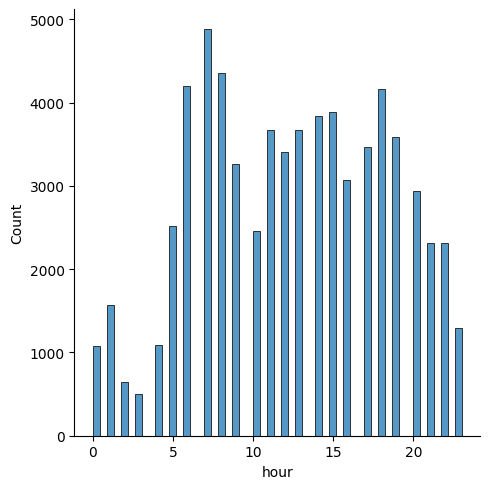

In [11]:
sns.displot(df[HOUR], palette = sns.color_palette("Set2",2))

## Destination-i
---
Destination programmaded, top destination

In [12]:
DESI = 'Des-I'
df[DESI].value_counts().sort_values(ascending=False).head(5)

SCFA    5787
SPJC    5270
SCCF    5145
SCTE    4357
SCIE    3995
Name: Des-I, dtype: int64

---
## Flight type

Fligth type, I stand for international and N stand for national

In [13]:
top_destination = df[DESI].value_counts().sort_values(ascending=False).head(2).index.tolist()
to_plot = df.groupby([DATE, TIPOVUELO])[TIPOVUELO].count().rename("count")
to_plot = to_plot.reset_index()
to_plot.Date.nunique()

365

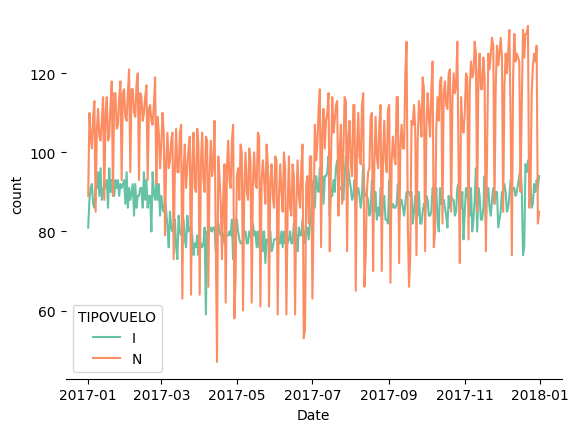

In [14]:
sns.lineplot(x=DATE, y = 'count', data = to_plot, hue=TIPOVUELO, palette = sns.color_palette("Set2",2))# palette = sns.color_palette("Paired",1))
sns.despine(left=True)

For this airport we have more national flights than international. Also have the similar demand each day.

We can verify this with the following plot, where we have the same distribution but slighty different between the number of national and internation flights


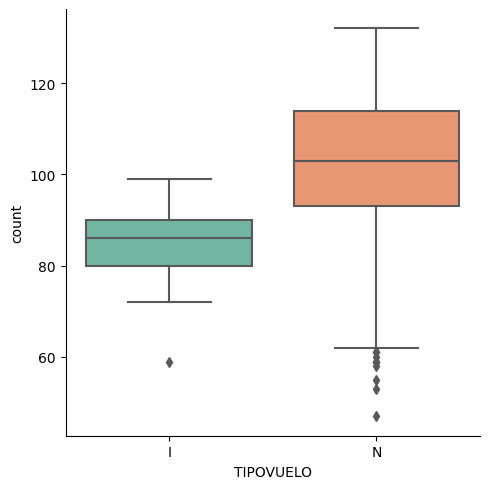

In [15]:
to_plot = df.groupby([DATE, TIPOVUELO])[TIPOVUELO].count().rename("count")
to_plot = to_plot.reset_index()
bar = sns.catplot(x=TIPOVUELO, y="count", kind="box",data=to_plot, palette = sns.color_palette("Set2",2))

# 2 Feature engineering

For this part we follow the indication to generate use full data, for this we use the function `pipe` from a dataframe



In [16]:
# genereate the a list of temporada alta provided by the company
dates = generate_temporada_alta_set()
# generate the interval for each day section, we only use two, be cause we can infered the third
times = generate_day_section()

In [17]:
df = pd.read_csv("latam_challenge/sources/raw/dataset_SCL.csv", dtype={'Vlo-O':str, 'Vlo-I':str})
df[FECHAO] = pd.to_datetime(df[FECHAO])
df = (df.pipe(split_date, FECHAI) # split the date into date %y-%m-%d and time %H:%M
        .pipe(add_temporada_alta_flag, dates) # add the temporada alta flag
        .pipe(add_periodo_dia_flag, times) # add periodo dia flag 
        .pipe(add_dif_min_and_atraso_15) # generate dif min and generate delay flag
     )
df[COLUM_SYNTHETIC_FEATURES].to_csv('synthetic_features.csv',index= False)

Similar columns
* Ori-I y Pri-o only one origin
* Des-I y SIGLADES is the same information
- OPERA == Emp-I as the same 

modificadores
- Vlo-I != Vlo-O, if we have the number of flight is different in the operational this mean that maybe the flight was cancelled or delayed
- Des-I != Des-O, can we consider same as Vlo? 

**we will not consider this, we only consider the delay with different flight or destination, however, next iteration we could review this information**

**Also we will not consider -O columns because their consequence and not the effect**

# Flight delay
As we can see in the documentation, we have a flight delay when the departure take more than 15 minutes. The information provided not show an external factors such weather

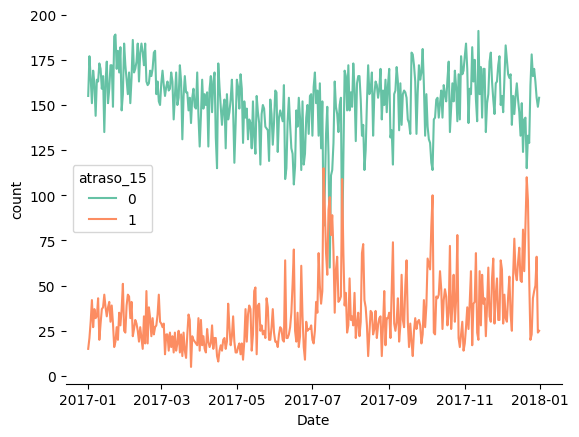

In [18]:
to_plot = df.groupby([DATE, ATRASO_15])[ATRASO_15].count().rename("count")
to_plot = to_plot.reset_index()
sns.lineplot(x=DATE, y = 'count', data = to_plot, palette = sns.color_palette("Set2",2), hue = ATRASO_15)
sns.despine(left=True)

We have an outlier between 2017-07 and  2017-09 where th delay increase and is inversely proportional to no delay. Also we can review the impact on delay between the day

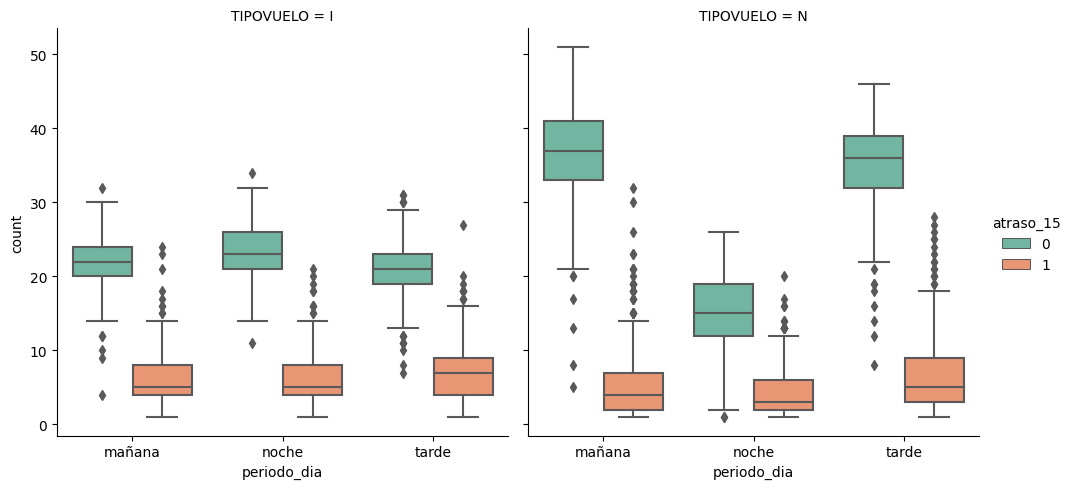

In [19]:
to_plot = df.groupby([DATE,'TIPOVUELO', PERIODO_DIA, ATRASO_15, ])[ATRASO_15].count().rename("count")
to_plot = to_plot.reset_index()
bar = sns.catplot(x=PERIODO_DIA, y="count", data=to_plot, hue=ATRASO_15, col='TIPOVUELO',kind="box", palette = sns.color_palette("Set2",2)) 


We take the the top two airlines to see the relationship between delay or not in the day, but as we can see in the following plot there is not bias

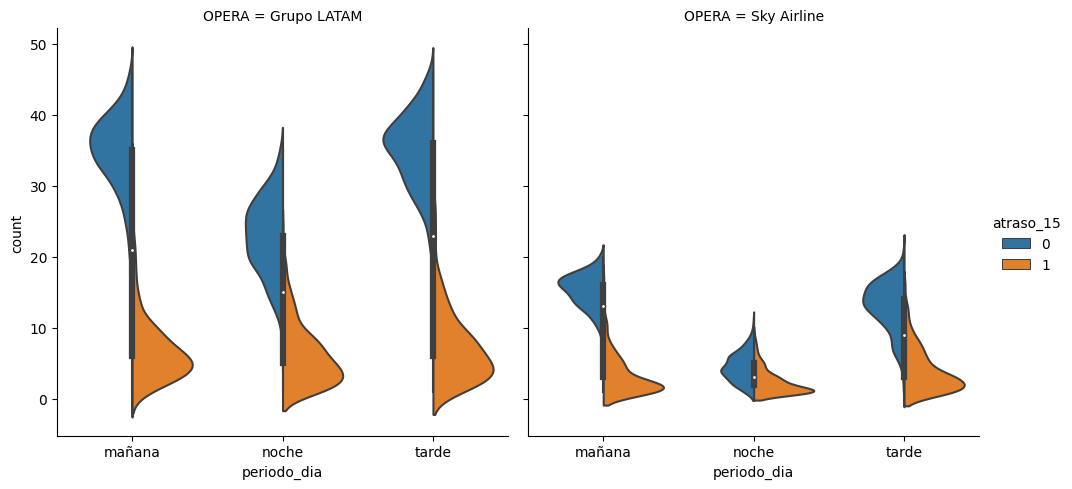

In [20]:
top = df[df[ATRASO_15]==1][OPERA].value_counts().sort_values(ascending=False).head(2).index.tolist()
to_plot = df[df[OPERA].isin(top)].groupby([DATE,OPERA, PERIODO_DIA, ATRASO_15, ])[ATRASO_15].count().rename("count")
to_plot = to_plot.reset_index()
bar = sns.catplot(x=PERIODO_DIA, y="count", data=to_plot, hue=ATRASO_15, col='OPERA',kind="violin", split=True)# palette = sns.color_palette("Paired",2)) 


Another analysis that we explor is the top international destionation with delay a long the day but we don see a notoried diference

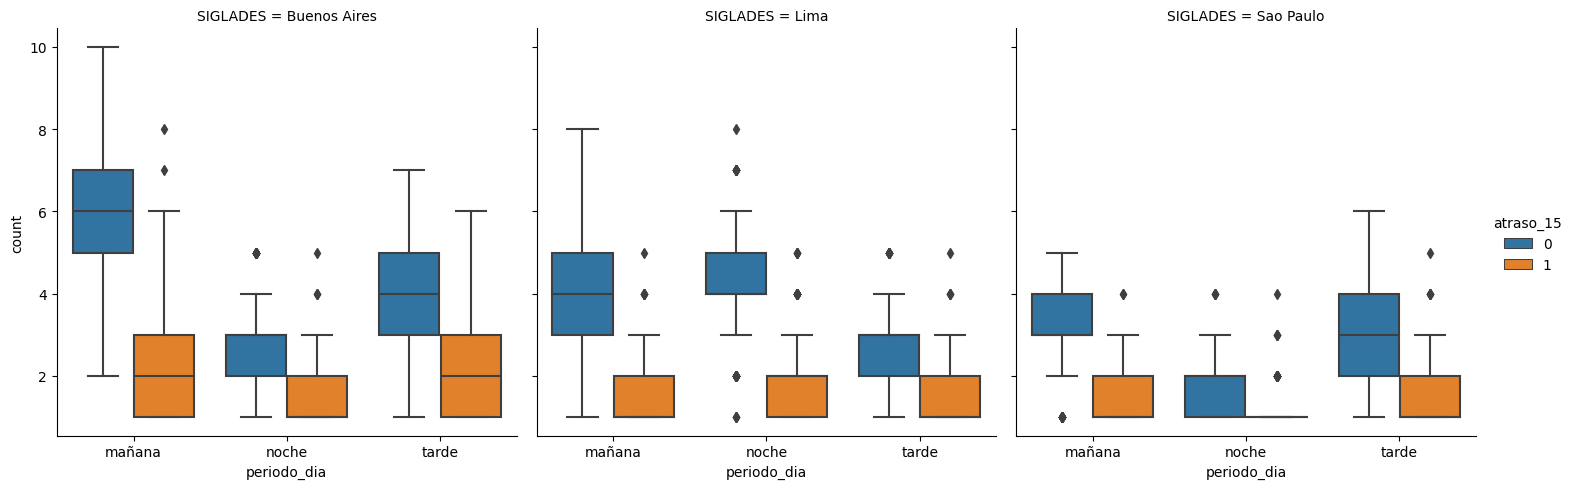

In [21]:
top = df[(df[ATRASO_15]==1) & (df['TIPOVUELO']=='I') ][SIGLADES].value_counts().sort_values(ascending=False).head(3).index.tolist()
to_plot = df[df[SIGLADES].isin(top)].groupby([DATE,SIGLADES, PERIODO_DIA, ATRASO_15, ])[ATRASO_15].count().rename("count")
to_plot = to_plot.reset_index()
bar = sns.catplot(x=PERIODO_DIA, y="count", data=to_plot, hue=ATRASO_15, col=SIGLADES,kind="box",)# palette = sns.color_palette("Paired",2)) 


# 3 Review if there is difference between the programmed vs operation

in `latam_challenge/notebook/LAT-004-Data-Augmentation.ipynb` 
 we have more information about the relationship between delay and other variables, 

In [22]:
# city code
rate = df.sort_values(ATRASO_15,ascending=False).groupby(['Des-I', ATRASO_15])[ATRASO_15].count().rename("count")
rate = rate / rate.groupby(level=0).sum()
rate.reset_index().head(10)

,Des-I,atraso_15,count
0,CYYZ,0,0.685512
1,CYYZ,1,0.314488
2,EGLL,0,0.858537
3,EGLL,1,0.141463
4,EGYP,1,1.000000
5,KATL,0,0.941341
6,KATL,1,0.058659
7,KDFW,0,0.929972
8,KDFW,1,0.070028
9,KIAH,0,0.949254


The top city code destionation with delay, where the most delay is Canada

In [23]:
# airline code
rate = df.sort_values(ATRASO_15,ascending=False).groupby(['Emp-I', ATRASO_15])[ATRASO_15].count().rename("count")
rate = rate / rate.groupby(level=0).sum()
rate.reset_index().head(10)

,Emp-I,atraso_15,count
0,AAL,0,0.932629
1,AAL,1,0.067371
2,ACA,0,0.543363
3,ACA,1,0.456637
4,AFR,0,0.916201
5,AFR,1,0.083799
6,AMX,0,0.971510
7,AMX,1,0.028490
8,ARG,0,0.759877
9,ARG,1,0.240123


in the case of the aireline, this depends in the numbers of flights and the aireline size, even we have the rate this require a different analysis, however if we only review the delay AAL is the lowes with delay

In [24]:
# top delay and non delay rate by day
rate = df.sort_values(ATRASO_15,ascending=False).groupby([DATE, ATRASO_15])[ATRASO_15].count().rename("count")
rate = rate / rate.groupby(level=0).sum()
rate.reset_index()

,Date,atraso_15,count
0,2017-01-01,0,0.911765
1,2017-01-01,1,0.088235
2,2017-01-02,0,0.893939
3,2017-01-02,1,0.106061
4,2017-01-03,0,0.846154
...,...,...,...
725,2017-12-29,1,0.300000
726,2017-12-30,0,0.861272
727,2017-12-30,1,0.138728
728,2017-12-31,0,0.860335


The best day to dont have delay is the first day of the year, however the worst day is the last day of the year

Other rates 

In [25]:
# top delay by day, this is by the demand, sunday has less delay than wednesday
rate = df.sort_values(ATRASO_15,ascending=False).groupby(['DIANOM', ATRASO_15])[ATRASO_15].count().rename("count")
rate = rate / rate.groupby(level=0).sum()
rate.reset_index().head(10)

,DIANOM,atraso_15,count
0,Domingo,0,0.838914
1,Domingo,1,0.161086
2,Jueves,0,0.800507
3,Jueves,1,0.199493
4,Lunes,0,0.797848
5,Lunes,1,0.202152
6,Martes,0,0.830884
7,Martes,1,0.169116
8,Miercoles,0,0.829150
9,Miercoles,1,0.170850


# Model Training

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

In [27]:
# Load again the data to run the full pipeline

In [28]:
df = pd.read_csv("latam_challenge/sources/raw/dataset_SCL.csv", dtype={'Vlo-O':str, 'Vlo-I':str})
df[FECHAO] = pd.to_datetime(df[FECHAO])
df = (df.pipe(split_date, FECHAI) # split the date into date %y-%m-%d and time %H:%M
        .pipe(add_temporada_alta_flag, dates) # add the temporada alta flag
        .pipe(add_periodo_dia_flag, times) # add periodo dia flag 
        .pipe(add_dif_min_and_atraso_15) # generate dif min and generate delay flag
        .pipe(delete_operational_columns) # delte all 
        .pipe(filter_column) # keep non -o columns
        .pipe(one_hot_encoder) # generate one_hot_encoder
        .pipe(to_bool_tipo_vuelo) # change to bool flight type
     )

In [29]:
md(f"for one hot encoder is used to for non numeric columns such as {VLOI}, {DIANOM}, {OPERA}, {SIGLADES}, {TEMPORADA_ALTA}, {PERIODO_DIA}")


for one hot encoder is used to for non numeric columns such as Vlo-I, DIANOM, OPERA, SIGLADES, temporada_alta, periodo_dia

In [30]:
columns = df.columns
columns = columns.tolist()
columns.remove(FECHAI)
df = df[columns]
columns.remove(ATRASO_15)

# KNeighbors Classifier

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
        df[columns],
        df[ATRASO_15],
        test_size=.8,
        random_state=42,
    )

the baseline probability is   81.61 %, this mean that if we take randomly one flight we have 81.61 % of chance that this flight will be not delayed

In [32]:
y_test.value_counts()/y_test.shape[0]

0    0.816128
1    0.183872
Name: atraso_15, dtype: float64

In [33]:
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train, y_train)
y_pred = model.predict(X_test[columns])


In [34]:
recall_score(y_test, y_pred)

0.0794378550782418

In [35]:
accuracy_score(y_test, y_pred)

0.8150096215522771

In [36]:
confusion_matrix(y_test, y_pred)

array([[43674,   858],
       [ 9236,   797]])

# Random Forest Classifier

In [35]:
rfc_st = RandomForestClassifier(random_state=42)

In [36]:
model = fit_grid_model(rfc_st, PARAM_GRID, X_train, y_train)
y_pred = model.predict(X_test)

In [37]:
confusion_matrix(y_test, y_pred)

array([[44333,   199],
       [ 9653,   380]])

In [38]:
accuracy_score(y_test, y_pred)

0.8194446989828644

In [39]:
recall_score(y_test, y_pred)

0.03787501245888568

Random forest took create partition between the data and identify the best cut using entropy or gini. Also this model allows to identify the top columns that can are easiest to split the data. In the case of KNN, the process is not supervised and this process look which are nearest neighborh.

In the case of RF, we have a best accuracy howerver, we increase the false postive  but is reduced the true negative. 

The selection of the model could be for production choose the knn howerver to explain the model I will use the random forest

### we can improve the training using k-folds

In [108]:
feature_names = [f"feature {i}" for i in range(df.shape[1])]
best_model = model.best_estimator_

In [109]:
best_model

RandomForestClassifier(max_depth=16, max_features='sqrt', n_estimators=50,
                       n_jobs=2, random_state=42)

<AxesSubplot:>

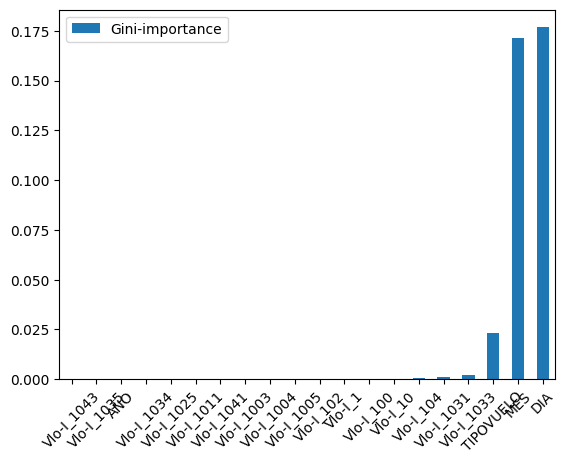

In [116]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df[columns], best_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.head(20)
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

The top importance was month, day and flight type, this could be because if a flight is delayed the change of delayed increase for the following flight, in the case of the month could be by the split and we require to check p for , finally we detect some flights that are more delayed